### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [362]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
334,PSID150,0,22,11,0,1,0,1,7341.373,2535.0970,14187.650
574,PSID390,0,48,13,0,0,1,0,0.000,0.0000,0.000
424,PSID240,0,16,10,0,1,0,1,0.000,630.1935,3892.332
291,PSID107,0,19,12,0,0,1,0,5817.063,3919.0160,1066.919
117,NSW118,1,20,12,1,0,0,0,0.000,377.5686,1652.637
490,PSID306,0,35,13,0,0,0,0,9537.711,0.0000,11269.140
506,PSID322,0,23,12,0,0,0,0,3893.063,0.0000,16324.450
51,NSW52,1,31,11,1,0,1,1,0.000,0.0000,8087.487
353,PSID169,0,25,9,0,0,1,1,23377.970,1901.3230,1898.879
230,PSID46,0,20,12,1,0,1,0,9555.344,7055.6610,0.000


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

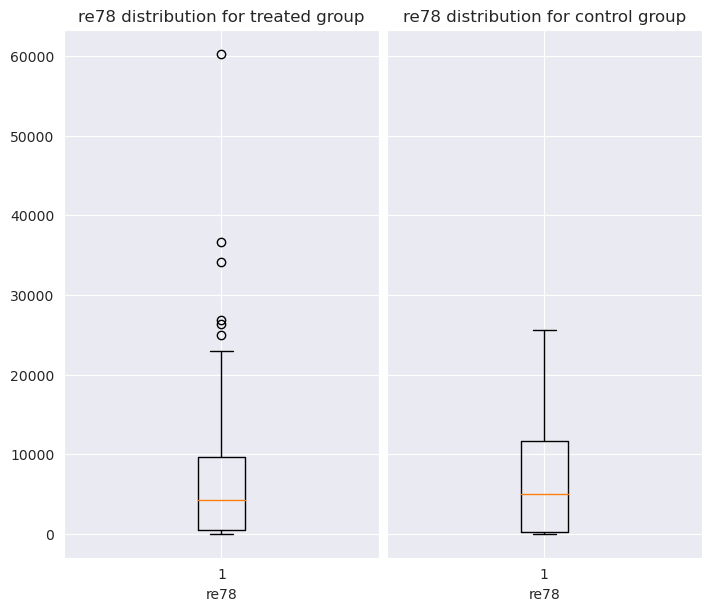

In [298]:
''' your code and explanations '''
treated = df.query('treat == 1')
control = df.query('treat == 0')

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 6), layout='constrained')

ax[0].boxplot(treated.re78)
ax[0].set_title('re78 distribution for treated group')
ax[0].set_xlabel('re78')

ax[1].boxplot(control.re78)
ax[1].set_title('re78 distribution for control group')
ax[1].set_xlabel('re78')

plt.show()

treat                  0             1
re78 count    429.000000    185.000000
     mean    6984.169742   6349.143530
     std     7294.161791   7867.402218
     min        0.000000      0.000000
     25%      220.181300    485.229800
     50%     4975.505000   4232.309000
     75%    11688.820000   9642.999000
     max    25564.670000  60307.930000


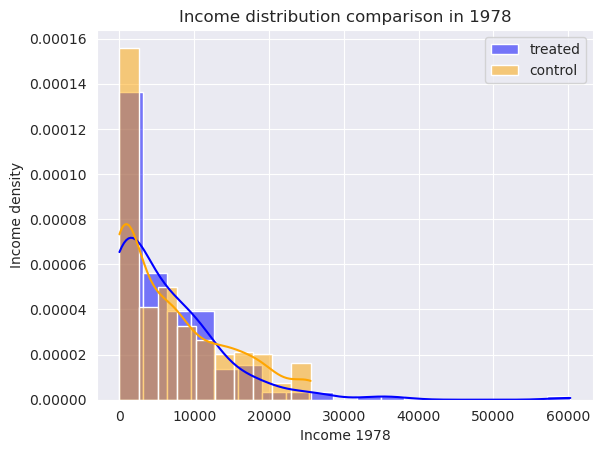

In [507]:
ax = sns.histplot(treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.legend()
print(df[['re78', 'treat']].groupby('treat').describe().T)
plt.show()

- Control group has higher earning mean
- Treated group has a higher first quartile ($25\%$) $485.23$ vs $220.18$
- There is some outlier with really high income in the treated group
- The control group has higher $50\%$ and $75\%$ percentil income than the treated group

We can conclude than in general the control group performs better than the treated group. (Which is not what we would like to observe)

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

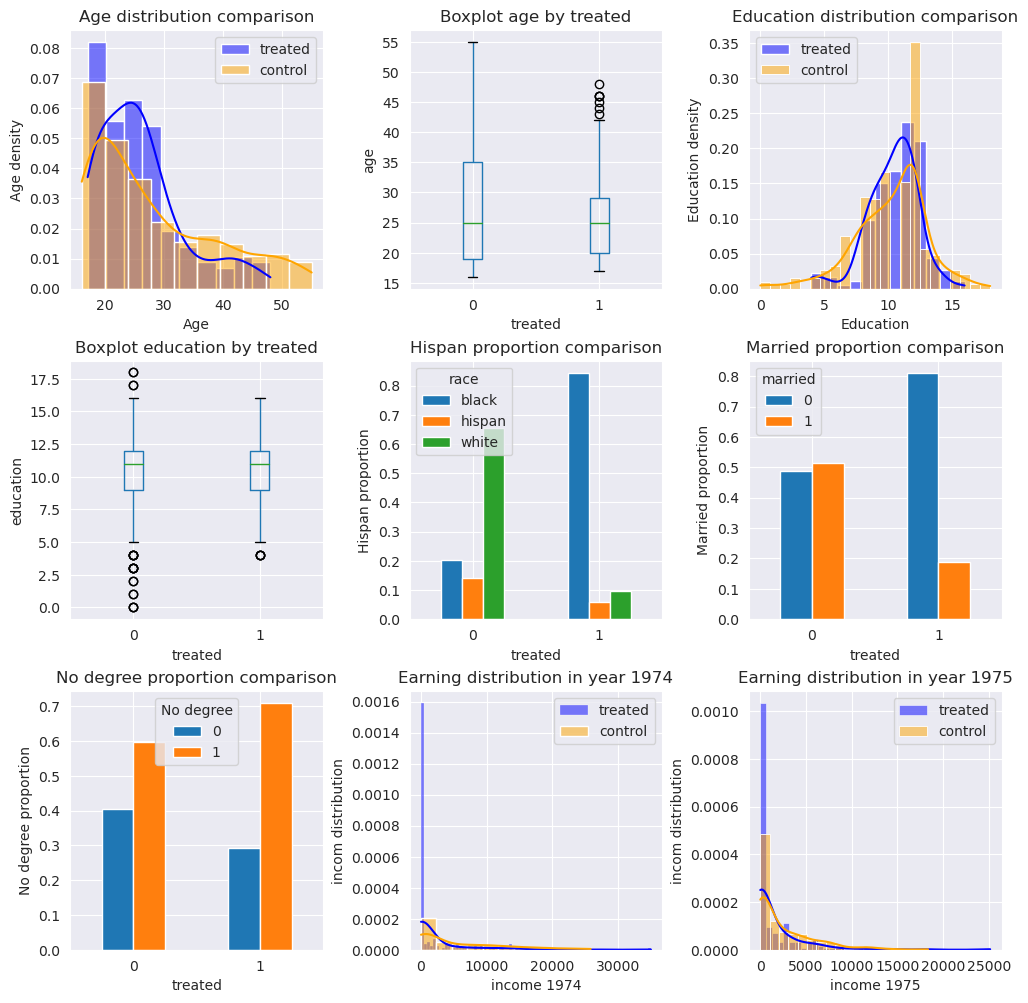

In [354]:
''' your code and explanations '''
fig, ax = plt.subplots(3, 3, figsize = (10, 10), layout='constrained')

# Age feature
sns.histplot(treated.age, kde=True, stat='density', color='blue', label='treated', ax=ax[0, 0])
sns.histplot(control.age, kde=True, stat='density', color='orange', label='control', ax=ax[0, 0])
ax[0, 0].legend()
ax[0, 0].set(title='Age distribution comparison',xlabel='Age', ylabel='Age density')

df.boxplot(by='treat', column='age', ax=ax[0, 1])
ax[0, 1].set(title='Boxplot age by treated', xlabel='treated', ylabel='age')

# Educ feature
sns.histplot(treated.educ, kde=True, stat='density', color='blue', label='treated', ax=ax[0, 2])
sns.histplot(control.educ, kde=True, stat='density', color='orange', label='control', ax=ax[0, 2])
ax[0, 2].legend()
ax[0, 2].set(title='Education distribution comparison',xlabel='Education', ylabel='Education density')

df.boxplot(by='treat', column='educ', ax=ax[1, 0])
ax[1, 0].set(title='Boxplot education by treated', xlabel='treated', ylabel='education')

# Race
df_race = df[['treat', 'black', 'hispan']].copy()
df_race['white'] = ((df['black'] == 0) * (df['hispan'] == 0)) * 1 # create new white column
df_race = df_race.groupby('treat').sum()
df_race = df_race.div(df_race.sum(axis=1), axis=0)
df_race.plot.bar(rot=0, ax=ax[1, 1])
ax[1, 1].set(title='Hispan proportion comparison',xlabel='treated', ylabel='Hispan proportion')
ax[1, 1].legend(title='race', loc=2)

# Married
group_married = df.groupby(['treat', 'married'])['treat'].count().unstack()
group_married = group_married.div(group_married.sum(axis=1), axis=0)
group_married.plot.bar(rot=0, ax=ax[1,2])
ax[1, 2].set(title='Married proportion comparison',xlabel='treated', ylabel='Married proportion')

# No degree
group_nodegree = df.groupby(['treat', 'nodegree'])['treat'].count().unstack()
group_nodegree = group_nodegree.div(group_nodegree.sum(axis=1), axis=0)
group_nodegree.plot.bar(rot=0, ax=ax[2, 0])
ax[2, 0].set(title='No degree proportion comparison', xlabel='treated', ylabel='No degree proportion')
ax[2, 0].legend(title='No degree', loc=9)

# Earning previous year
sns.histplot(treated.re74, kde=True, stat='density', color='blue', label='treated', ax=ax[2, 1])
sns.histplot(control.re74, kde=True, stat='density', color='orange', label='control', ax=ax[2, 1])
ax[2, 1].set(title='Earning distribution in year 1974', xlabel='income 1974', ylabel='income distribution')
ax[2, 1].legend()

sns.histplot(treated.re75, kde=True, stat='density', color='blue', label='treated', ax=ax[2, 2])
sns.histplot(control.re75, kde=True, stat='density', color='orange', label='control', ax=ax[2, 2])
ax[2, 2].set(title='Earning distribution in year 1975', xlabel='income 1975', ylabel='income distribution')
ax[2, 2].legend()

fig.suptitle('')
plt.show()

From the above plots, we can see multiple things

- The treated group tend to be younger than the control group
- The education level of the treated group tend to be a little bit higher than the one from the control group, and there is more outlier in the control group
- The proportion of unmarried people is much higher in the treated group, maybe unmarried people tend to join the treatment more easily (different kind of people)
- The proportion of people with no school degree is higher in the treated group than it is in the control group
- We can see that in 1974, a lot of the treated group didn't earn any money
- We can see that in 1975, it there was already fewer people from the treated group that didn't earn any money, so the program did work a bit
- We can see that the white people are a lot more on the control group, but on the other hand on the treated group it is the black people that are the most represented.

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

### First Standardize the continuous data

In [359]:
df_std = df.copy()
df_std.age = (df_std.age - df_std.age.mean())/df_std.age.std() 
df_std.educ = (df_std.educ - df_std.educ.mean())/df_std.educ.std()
df_std.re74 = (df_std.re74 - df_std.re74.mean())/df_std.re74.std()
df_std.re75 = (df_std.re75 - df_std.re75.mean())/df_std.re75.std()
df_std.re78 = (df_std.re78 - df_std.re78.mean())/df_std.re78.std()

In [404]:
mod = smf.logit(formula='treat ~ age + educ + C(black) + C(hispan) + C(married) + C(nodegree) + re74 + re75', data=df_std)
mod_fitted = mod.fit()

df_std['propensity_score'] = mod_fitted.predict()

print(mod_fitted.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sat, 04 Nov 2023   Pseudo R-squ.:                  0.3508
Time:                        16:24:21   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [422]:
# Similarity functions
# The closer to one, the more alike two samples are

def similarity(propensity_x, propensity_y):
    return 1 - np.abs(propensity_x - propensity_y)

In [423]:
''' your code and explanations '''
treated_propensity = df_std.query('treat == 1')
control_propensity = df_std.query('treat == 0')

# init graph
graph = nx.Graph()

for treated_idx, treated_ser in treated_propensity.iterrows():
    for control_idx, control_ser in control_propensity.iterrows():
        sim = similarity(control_ser.propensity_score, treated_ser.propensity_score)
        
        graph.add_weighted_edges_from([(control_idx, treated_idx, sim)])

matching = nx.max_weight_matching(graph)

In [438]:
# Extract every index from the matching and transform it into a list of index to index the df
l1, l2 = zip(*list(matching))
matched = list(l1) + list(l2)

matched_df = df.iloc[matched].copy()
matched_df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
410,PSID226,0,39,10,1,0,0,1,844.444,889.7903,701.9201
51,NSW52,1,31,11,1,0,1,1,0.000,0.0000,8087.4870
99,NSW100,1,31,9,0,1,0,1,0.000,0.0000,26817.6000
375,PSID191,0,18,12,1,0,0,0,1579.169,1408.9840,3057.4160
46,NSW47,1,17,8,1,0,0,1,0.000,0.0000,0.0000
320,PSID136,0,20,11,0,1,0,1,2868.367,2968.3550,7403.4100
609,PSID425,0,18,11,0,0,0,1,0.000,0.0000,10150.5000
26,NSW27,1,25,11,1,0,0,1,0.000,0.0000,9897.0490
36,NSW37,1,25,5,1,0,0,1,0.000,0.0000,6181.8800
114,NSW115,1,27,12,1,0,1,0,3670.872,334.0493,0.0000


### Look at the data as in part 2

In [439]:
matched_treated = matched_df.query('treat == 1')
matched_control = matched_df.query('treat == 0')

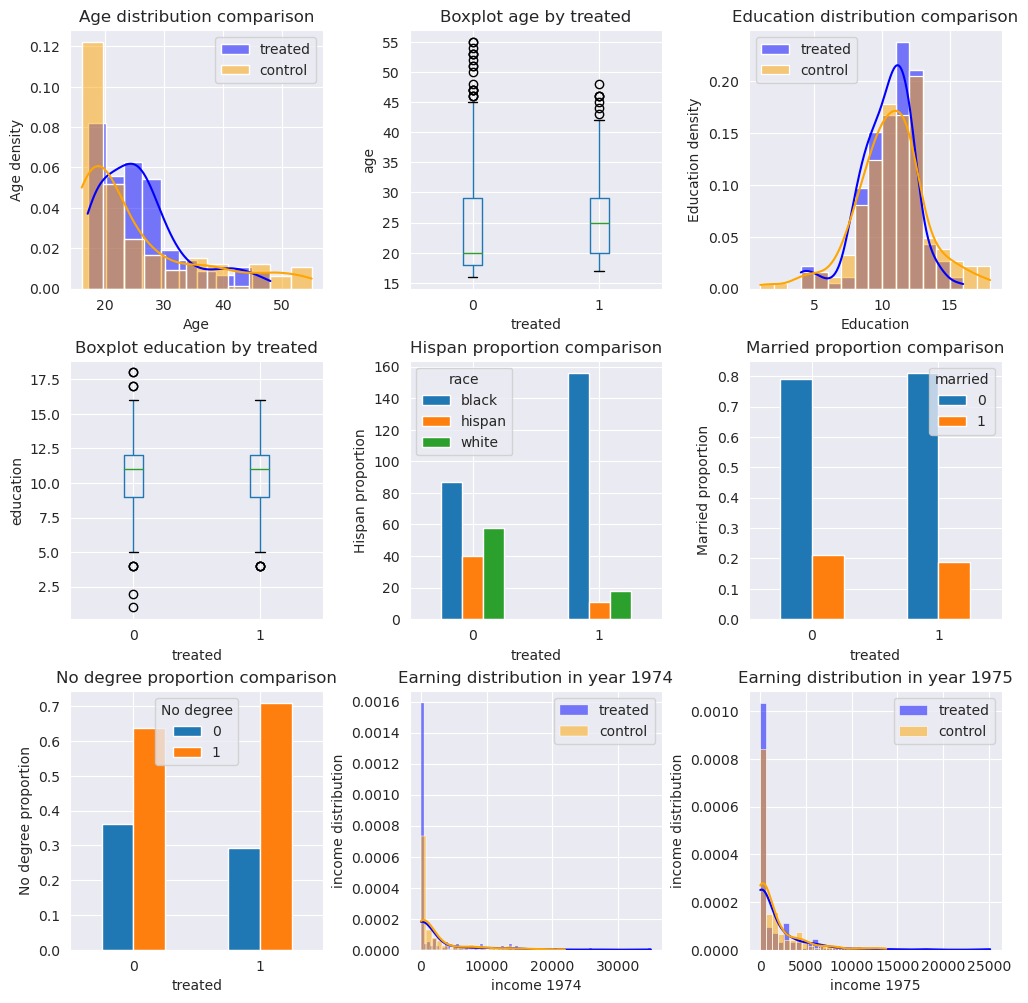

In [449]:
fig, ax = plt.subplots(3, 3, figsize = (10, 10), layout='constrained')

# Age feature
sns.histplot(matched_treated.age, kde=True, stat='density', color='blue', label='treated', ax=ax[0, 0])
sns.histplot(matched_control.age, kde=True, stat='density', color='orange', label='control', ax=ax[0, 0])
ax[0, 0].legend()
ax[0, 0].set(title='Age distribution comparison',xlabel='Age', ylabel='Age density')

matched_df.boxplot(by='treat', column='age', ax=ax[0, 1])
ax[0, 1].set(title='Boxplot age by treated', xlabel='treated', ylabel='age')

# Educ feature
sns.histplot(matched_treated.educ, kde=True, stat='density', color='blue', label='treated', ax=ax[0, 2])
sns.histplot(matched_control.educ, kde=True, stat='density', color='orange', label='control', ax=ax[0, 2])
ax[0, 2].legend()
ax[0, 2].set(title='Education distribution comparison',xlabel='Education', ylabel='Education density')

matched_df.boxplot(by='treat', column='educ', ax=ax[1, 0])
ax[1, 0].set(title='Boxplot education by treated', xlabel='treated', ylabel='education')

# Race
matched_df_race = matched_df[['treat', 'black', 'hispan']].copy()
matched_df_race['white'] = ((matched_df['black'] == 0) * (matched_df['hispan'] == 0)) * 1 # create new white column
matched_df_race = matched_df_race.groupby('treat').sum()
matched_df_race = matched_df_race.div(df_race.sum(axis=1), axis=0)
matched_df_race.plot.bar(rot=0, ax=ax[1, 1])
ax[1, 1].set(title='Hispan proportion comparison',xlabel='treated', ylabel='Hispan proportion')
ax[1, 1].legend(title='race', loc=2)

# Married
matched_group_married = matched_df.groupby(['treat', 'married'])['treat'].count().unstack()
matched_group_married = matched_group_married.div(matched_group_married.sum(axis=1), axis=0)
matched_group_married.plot.bar(rot=0, ax=ax[1,2])
ax[1, 2].set(title='Married proportion comparison',xlabel='treated', ylabel='Married proportion')

# No degree
matched_group_nodegree = matched_df.groupby(['treat', 'nodegree'])['treat'].count().unstack()
matched_group_nodegree = matched_group_nodegree.div(matched_group_nodegree.sum(axis=1), axis=0)
matched_group_nodegree.plot.bar(rot=0, ax=ax[2, 0])
ax[2, 0].set(title='No degree proportion comparison', xlabel='treated', ylabel='No degree proportion')
ax[2, 0].legend(title='No degree', loc=9)

# Earning previous year
sns.histplot(matched_treated.re74, kde=True, stat='density', color='blue', label='treated', ax=ax[2, 1])
sns.histplot(matched_control.re74, kde=True, stat='density', color='orange', label='control', ax=ax[2, 1])
ax[2, 1].set(title='Earning distribution in year 1974', xlabel='income 1974', ylabel='income distribution')
ax[2, 1].legend()

sns.histplot(matched_treated.re75, kde=True, stat='density', color='blue', label='treated', ax=ax[2, 2])
sns.histplot(matched_control.re75, kde=True, stat='density', color='orange', label='control', ax=ax[2, 2])
ax[2, 2].set(title='Earning distribution in year 1975', xlabel='income 1975', ylabel='income distribution')
ax[2, 2].legend()

fig.suptitle('')
plt.show()

From the above plots, we can see that in general the matched population is much more comparable

- Both population have more or less the same age, but this time the treated group tend to be a bit older
- The education level of both group are more or less the same.
- The proportion of married people is almost the same between the treated and untreated group
- The proportion of people with no school degree is slightly higher in the treated group, but much less than before
- We can see that in 1974, a lot of the treated group didn't earn any money
- We can see that in 1975, it there was already fewer people from the treated group that didn't earn any money, so the program did work a bit
- We can see that the white people are a lot more on the control group, but on the other hand on the treated group it is the black people that are the most represented.
  **The matching didn't help for the race**

treat                  0             1
re78 count    185.000000    185.000000
     mean    5454.776050   6349.143530
     std     6063.836916   7867.402218
     min        0.000000      0.000000
     25%        0.000000    485.229800
     50%     3358.873000   4232.309000
     75%     7933.914000   9642.999000
     max    23764.800000  60307.930000


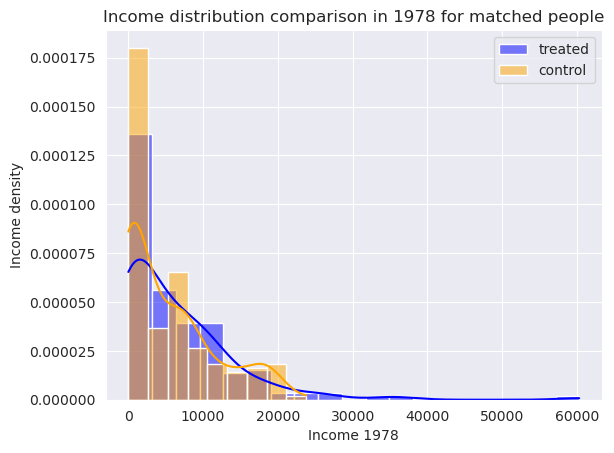

In [470]:
ax = sns.histplot(matched_treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(matched_control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978 for matched people',xlabel='Income 1978', ylabel='Income density')
plt.legend()
print(matched_df[['re78', 'treat']].groupby('treat').describe().T)
plt.show()

Here, it is the opposite than before. The treated group is better on every point. Higher mean, higher 25, 50 and 75 percentile.

And the data is much more comparable, there is less observed covariates as we used the propensity score to do the matching. The only big difference that is left is the race discrepancy. 

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [502]:
treated_propensity = df_std.query('treat == 1')
control_propensity = df_std.query('treat == 0')

# init graph
graph = nx.Graph()

test = []

for treated_idx, treated_ser in treated_propensity.iterrows():
    for control_idx, control_ser in control_propensity.iterrows():
        if control_ser.black == treated_ser.black and control_ser.hispan == treated_ser.hispan:
            # Only add if race is the same
            sim = similarity(control_ser.propensity_score, treated_ser.propensity_score)
            test.append(sim)

            graph.add_weighted_edges_from([(control_idx, treated_idx, sim)])
matching = nx.max_weight_matching(graph)

In [503]:
l1, l2 = zip(*list(matching))
matched = list(l1) + list(l2)

matched_df = df.iloc[matched].copy()
matched_df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
612,PSID428,0,32,5,1,0,1,1,0.000,0.0000,187.6713
103,NSW104,1,18,11,1,0,0,1,0.000,0.0000,4814.6270
604,PSID420,0,39,2,1,0,1,1,0.000,0.0000,964.9555
184,NSW185,1,33,11,1,0,1,1,14660.710,25142.2400,4181.9420
162,NSW163,1,24,10,1,0,1,1,11703.200,4078.1520,0.0000
55,NSW56,1,17,10,1,0,0,1,0.000,0.0000,0.0000
366,PSID182,0,18,11,0,0,0,1,1273.523,1532.5160,12489.7500
361,PSID177,0,19,11,0,0,0,1,0.000,1693.6450,9853.4810
574,PSID390,0,48,13,0,0,1,0,0.000,0.0000,0.0000
115,NSW116,1,21,12,0,0,0,0,3670.872,334.0494,12558.0200


In [504]:
matched_treated = matched_df.query('treat == 1')
matched_control = matched_df.query('treat == 0')

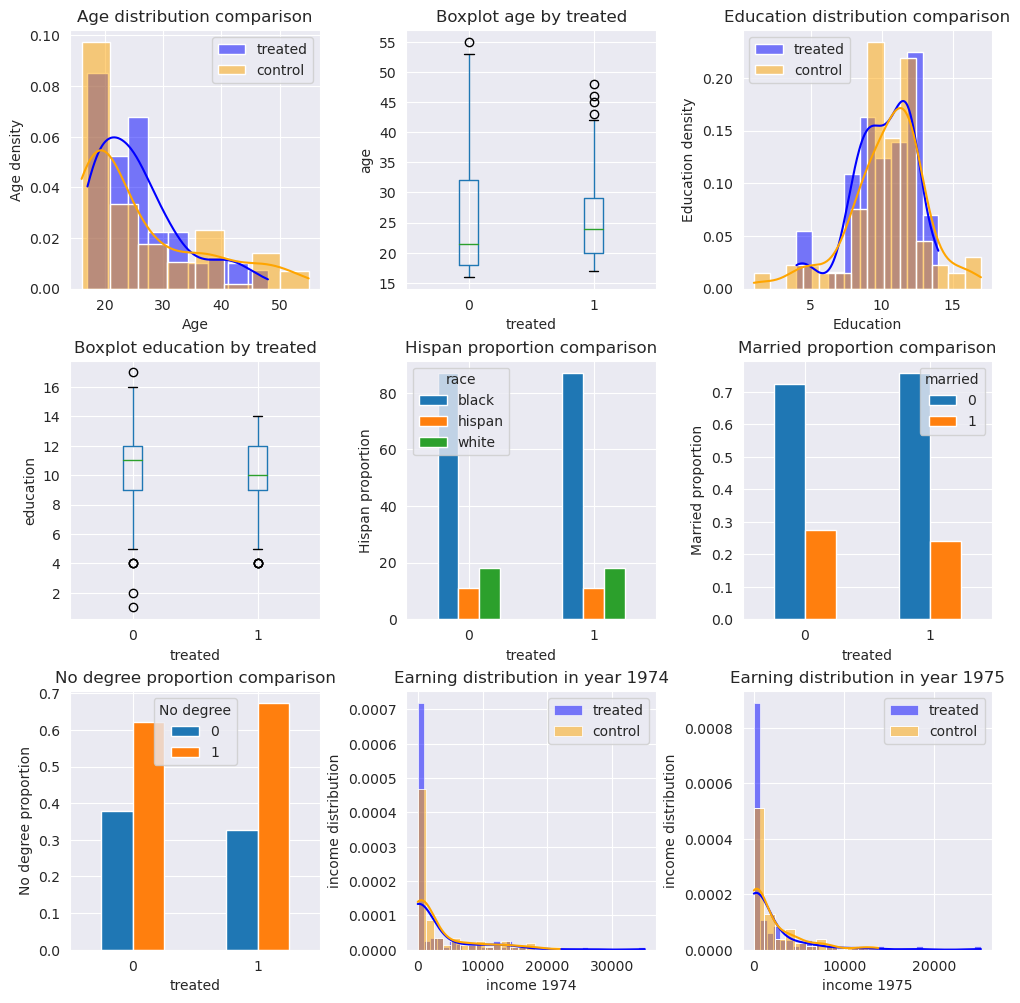

In [505]:
fig, ax = plt.subplots(3, 3, figsize = (10, 10), layout='constrained')

# Age feature
sns.histplot(matched_treated.age, kde=True, stat='density', color='blue', label='treated', ax=ax[0, 0])
sns.histplot(matched_control.age, kde=True, stat='density', color='orange', label='control', ax=ax[0, 0])
ax[0, 0].legend()
ax[0, 0].set(title='Age distribution comparison',xlabel='Age', ylabel='Age density')

matched_df.boxplot(by='treat', column='age', ax=ax[0, 1])
ax[0, 1].set(title='Boxplot age by treated', xlabel='treated', ylabel='age')

# Educ feature
sns.histplot(matched_treated.educ, kde=True, stat='density', color='blue', label='treated', ax=ax[0, 2])
sns.histplot(matched_control.educ, kde=True, stat='density', color='orange', label='control', ax=ax[0, 2])
ax[0, 2].legend()
ax[0, 2].set(title='Education distribution comparison',xlabel='Education', ylabel='Education density')

matched_df.boxplot(by='treat', column='educ', ax=ax[1, 0])
ax[1, 0].set(title='Boxplot education by treated', xlabel='treated', ylabel='education')

# Race
matched_df_race = matched_df[['treat', 'black', 'hispan']].copy()
matched_df_race['white'] = ((matched_df['black'] == 0) * (matched_df['hispan'] == 0)) * 1 # create new white column
matched_df_race = matched_df_race.groupby('treat').sum()
matched_df_race = matched_df_race.div(df_race.sum(axis=1), axis=0)
matched_df_race.plot.bar(rot=0, ax=ax[1, 1])
ax[1, 1].set(title='Hispan proportion comparison',xlabel='treated', ylabel='Hispan proportion')
ax[1, 1].legend(title='race', loc=2)

# Married
matched_group_married = matched_df.groupby(['treat', 'married'])['treat'].count().unstack()
matched_group_married = matched_group_married.div(matched_group_married.sum(axis=1), axis=0)
matched_group_married.plot.bar(rot=0, ax=ax[1,2])
ax[1, 2].set(title='Married proportion comparison',xlabel='treated', ylabel='Married proportion')

# No degree
matched_group_nodegree = matched_df.groupby(['treat', 'nodegree'])['treat'].count().unstack()
matched_group_nodegree = matched_group_nodegree.div(matched_group_nodegree.sum(axis=1), axis=0)
matched_group_nodegree.plot.bar(rot=0, ax=ax[2, 0])
ax[2, 0].set(title='No degree proportion comparison', xlabel='treated', ylabel='No degree proportion')
ax[2, 0].legend(title='No degree', loc=9)

# Earning previous year
sns.histplot(matched_treated.re74, kde=True, stat='density', color='blue', label='treated', ax=ax[2, 1])
sns.histplot(matched_control.re74, kde=True, stat='density', color='orange', label='control', ax=ax[2, 1])
ax[2, 1].set(title='Earning distribution in year 1974', xlabel='income 1974', ylabel='income distribution')
ax[2, 1].legend()

sns.histplot(matched_treated.re75, kde=True, stat='density', color='blue', label='treated', ax=ax[2, 2])
sns.histplot(matched_control.re75, kde=True, stat='density', color='orange', label='control', ax=ax[2, 2])
ax[2, 2].set(title='Earning distribution in year 1975', xlabel='income 1975', ylabel='income distribution')
ax[2, 2].legend()

fig.suptitle('')
plt.show()

This time we are good, we have the same race ratio 

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

treat                  0             1
re78 count    116.000000    116.000000
     mean    5095.456025   6166.431753
     std     6047.014862   6655.656670
     min        0.000000      0.000000
     25%        0.000000    672.490925
     50%     2256.488500   4300.659000
     75%     8942.092750  10001.218250
     max    20243.380000  36646.950000


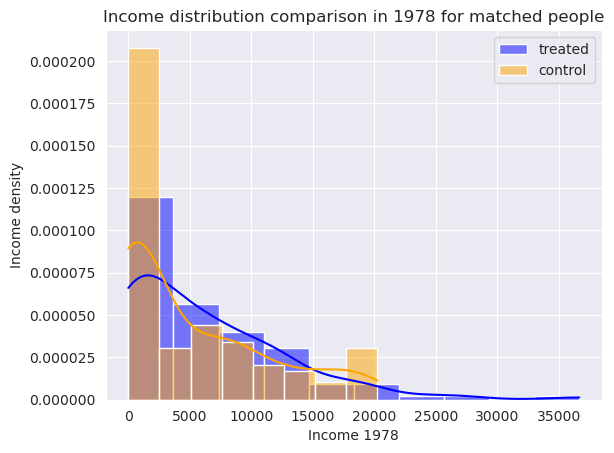

In [506]:
ax = sns.histplot(matched_treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(matched_control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978 for matched people',xlabel='Income 1978', ylabel='Income density')
plt.legend()
print(matched_df[['re78', 'treat']].groupby('treat').describe().T)
plt.show()

This time we can confidently conclude that the treated group has actually a better income after being treated.